In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Utility
import os
import glob
import random
import warnings
warnings.filterwarnings('ignore')
# Computer vision
from PIL import Image, ImageOps
# Data science
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import umap
# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import umap.plot
# Image processing
import cv2
from skimage import io, color, measure
import skimage.filters as skifilters
# Deep learning
# Consider aesthetics 
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['axes.axisbelow'] = True
plt.rcParams.update({'font.size': 16})
print("Libraries imported")

Libraries imported


We also create a `figure` folder to save figures produced

In [64]:
os.mkdir("/kaggle/working/figures")

# **Notebook outline**

**In this notebook, our objectives are as follows:**
1. Hanlde the dataset & create class labels
1. Perform exploratory data analysis
2. Based on the above analysis determine the correct pre-processing steps before model fitting

# **Data structure handling & class label creation**

The dataset is divided into three main folders, namely "train," "test," and "val," with each folder containing subfolders for microscopic fungi images of different fungi classes, specifically:

- H1: Candida albicans
- H2: Aspergillus niger
- H3: Trichophyton rubrum
- H5: Trichophyton mentagrophytes
- H6: Epidermophyton floccosum

We create tree typical hash map data structures for the train, validation and test set. 
First we utilize `glob` to grab all the image links in each subfolder that correspond to each of the classes using UNIX file searching:

In [4]:
targets = ["H1","H2","H3","H5","H6"]
dataset = ["test","train","valid"]
test_dict = {}
train_dict = {}
val_dict = {}
for target in targets:
    test_dict[target] = glob.glob(f"/kaggle/input/microscopic-fungi-images/test/{target}/*")
    train_dict[target] = glob.glob(f"/kaggle/input/microscopic-fungi-images/train/{target}/*")
    val_dict[target] = glob.glob(f"/kaggle/input/microscopic-fungi-images/valid/{target}/*")

Now lets investigate the balance of classes and the number of observations in each of the datasets. We use dictionary comprehensions to create new dictionaries for each dataset that showcase the counts of images per class key. 

In [5]:
test_class_dist = {key:len(value) for key,value in test_dict.items()}
train_class_dist = {key:len(value) for key,value in train_dict.items()}
val_class_dist = {key:len(value) for key,value in val_dict.items()}

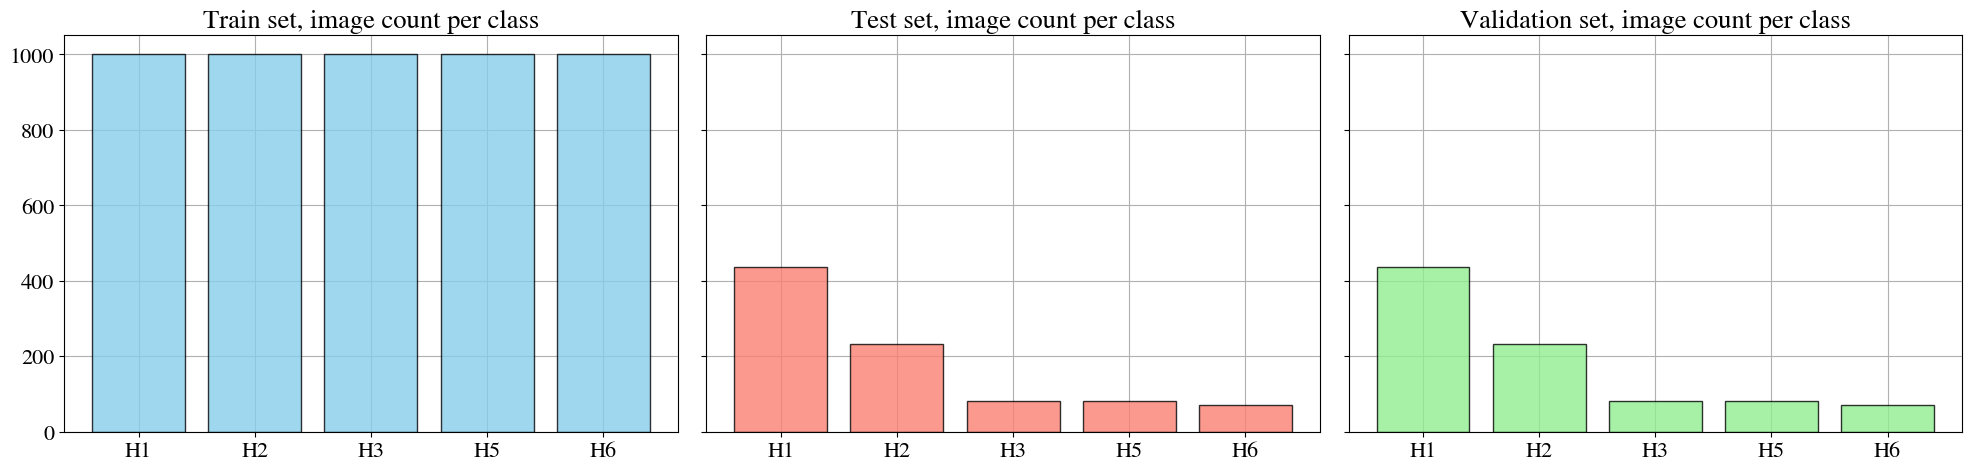

In [68]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5),sharey=True)
axes[0].bar(x = list(train_class_dist.keys()),height = train_class_dist.values(), color = "skyblue", edgecolor = "k",alpha = 0.8)
axes[0].set_title('Train set, image count per class')
axes[0].grid()
axes[1].bar(x = list(test_class_dist.keys()),height = test_class_dist.values(),color = "salmon", edgecolor = "k",alpha = 0.8)
axes[1].set_title('Test set, image count per class')
axes[1].grid()
axes[2].bar(x = list(val_class_dist.keys()),height = val_class_dist.values(),color = "lightgreen", edgecolor = "k",alpha = 0.8)
axes[2].set_title('Validation set, image count per class')
axes[2].grid()

plt.tight_layout()
plt.savefig('./figures/original_datasets.png', dpi=300) 
plt.show()

Its evident from the above that the test and validation splits of the above dataset are not exactly "fair", since while the model is trained on an equal distribution of images per class it is evaluated with imbalanced class distributions. There are a few ways to tackle this issue:
1. We could leave the dataset as is and utilized weighted evaluation metrics that take into account the balance of classes in the test and validation set
2. We could shuffle into the training set the test and validation set and create new stratified test and validation splits, here apart from the evaluation metrics we should also add weights to the loss function to emphasize the class imbalance 

We believe the second approach is a better option. Thus we create a new train, test , val split utilized the 80%, 10%, 10% rule of thumb.

In [7]:
complete_data_dict = {}
for data in [test_dict, train_dict, val_dict]:
    for key, value in data.items():
        if key in complete_data_dict:
            # Append values only if they are not already present
            complete_data_dict[key] = list(set(complete_data_dict[key] + value))
        else:
            complete_data_dict[key] = value

complete_data_class_dist = {key: len(value) for key, value in complete_data_dict.items()}
total_observations = np.sum(list(complete_data_class_dist.values()))
class_weights = np.array(list(complete_data_class_dist.values()))/total_observations

print(f"Number of total observations in the dataset: {total_observations}\n")
print(f"Class distributions in the complete dataset: {np.round(class_weights,2)}")

Number of total observations in the dataset: 6801

Class distributions in the complete dataset: [0.28 0.22 0.17 0.17 0.17]


As we can see we have a total of 6801 observations, with class distribution:

- H1: Candida albicans: $28\%$
- H2: Aspergillus niger: $22\%$
- H3: Trichophyton rubrum: $17\%$
- H5: Trichophyton mentagrophytes: $17\%$
- H6: Epidermophyton floccosum: $17\%$


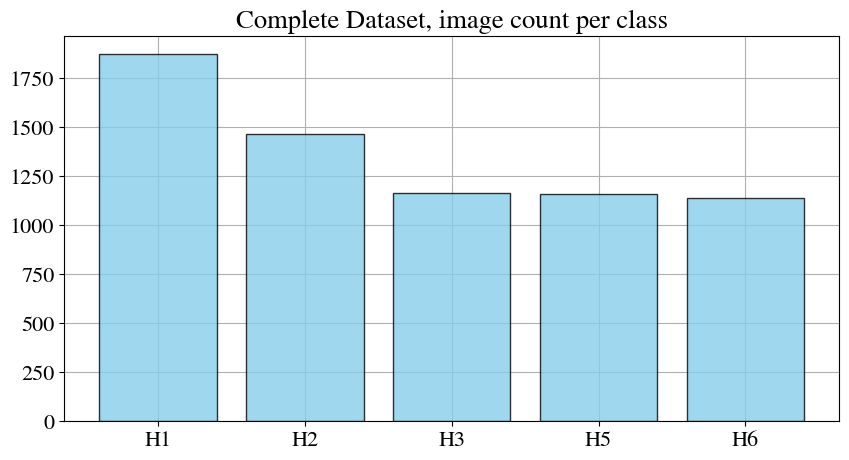

In [69]:
plt.figure(figsize = (10,5))
plt.bar(x = list(complete_data_class_dist.keys()), height = complete_data_class_dist.values(),edgecolor = "k", color = "skyblue",alpha = 0.8)
plt.title("Complete Dataset, image count per class")
plt.savefig('./figures/complete_dataset.png', dpi=300) 
plt.grid()

Lets go ahead and create integer class labels for each of the images 

In [10]:
class_labels = {0:"Candida albicans",
                1:"Aspergillus niger", 
                2:"Trichophyton rubrum", 
                3:"Trichophyton mentagrophytes", 
                4:"Epidermophyton floccosum"}

In [11]:
zero_class = list(np.zeros(complete_data_class_dist["H1"],dtype=int))
print(f"{len(zero_class)} 0 class labels")
one_class = list(np.ones(complete_data_class_dist["H2"],dtype=int))
print(f"{len(one_class)} 1 class labels")
two_class = list(np.ones(complete_data_class_dist["H3"],dtype=int) * 2)
print(f"{len(two_class)} 2 class labels")
three_class = list(np.ones(complete_data_class_dist["H5"],dtype=int) * 3)
print(f"{len(three_class)} 3 class labels")
four_class = list(np.ones(complete_data_class_dist["H6"],dtype=int) * 4)
print(f"{len(two_class)} 4 class labels")

1874 0 class labels
1465 1 class labels
1163 2 class labels
1160 3 class labels
1163 4 class labels


In [12]:
labels = zero_class + one_class + two_class + three_class + four_class
images = []

for class_image_lists in complete_data_dict.values():
    images.extend(class_image_lists)
    
print(f"We have a total of {len(labels)} targets")
print(f"We have a total of {len(images)} images")

We have a total of 6801 targets
We have a total of 6801 images


We can finally create the respective dataset dataframe

In [13]:
df = pd.DataFrame({"images":images,"labels":labels})
df.head()

,images,labels
0,/kaggle/input/microscopic-fungi-images/test/H1...,0
1,/kaggle/input/microscopic-fungi-images/train/H...,0
2,/kaggle/input/microscopic-fungi-images/train/H...,0
3,/kaggle/input/microscopic-fungi-images/valid/H...,0
4,/kaggle/input/microscopic-fungi-images/test/H1...,0


We need to make sure the labels are aligned correctly with the right image paths

In [14]:
for target in targets: 
    mask = df["images"].str.contains(target)
    print(f"\n Class: {target}\n Last Index: {df['images'][mask].index[-1]}")


 Class: H1
 Last Index: 1873

 Class: H2
 Last Index: 3338

 Class: H3
 Last Index: 4501

 Class: H5
 Last Index: 5661

 Class: H6
 Last Index: 6800


Observing the last index of each class, we can see the labels are correctly aligned with the images

## *Image exploration*
In order to get a random sample of images from the training set to inspect and load their respective RGB pixel values, we code the following function: `getRandomImages` which takes as input a dataframe, a random seed and the number of images we wish to retrieve. It then samples these images from the dataframe and loads them as `PIL` objects. 

In [15]:
def getRandomImages(dataframe,seed,sample_size):
    images = []
    labels = []
    np.random.seed(seed)
    random_indices = dataframe.sample(n=sample_size, replace=False, random_state=seed).index
    

    for index in random_indices:
        image_link = dataframe['images'][index]
        image_label = dataframe['labels'][index]
        image = Image.open(image_link)
        images.append(image)
        labels.append(image_label)
        
    return images,labels

#Call the function
images, labels = getRandomImages(dataframe = df,seed = 40,sample_size = 10)

In order to view the images and gain a first understanding, we create `supPlotimage` to present an illustration of the images we got from `getRandomImages` along with their:
- class labels
- image sizes
- intensity value range averaged across RGB channels
- mean intensity value

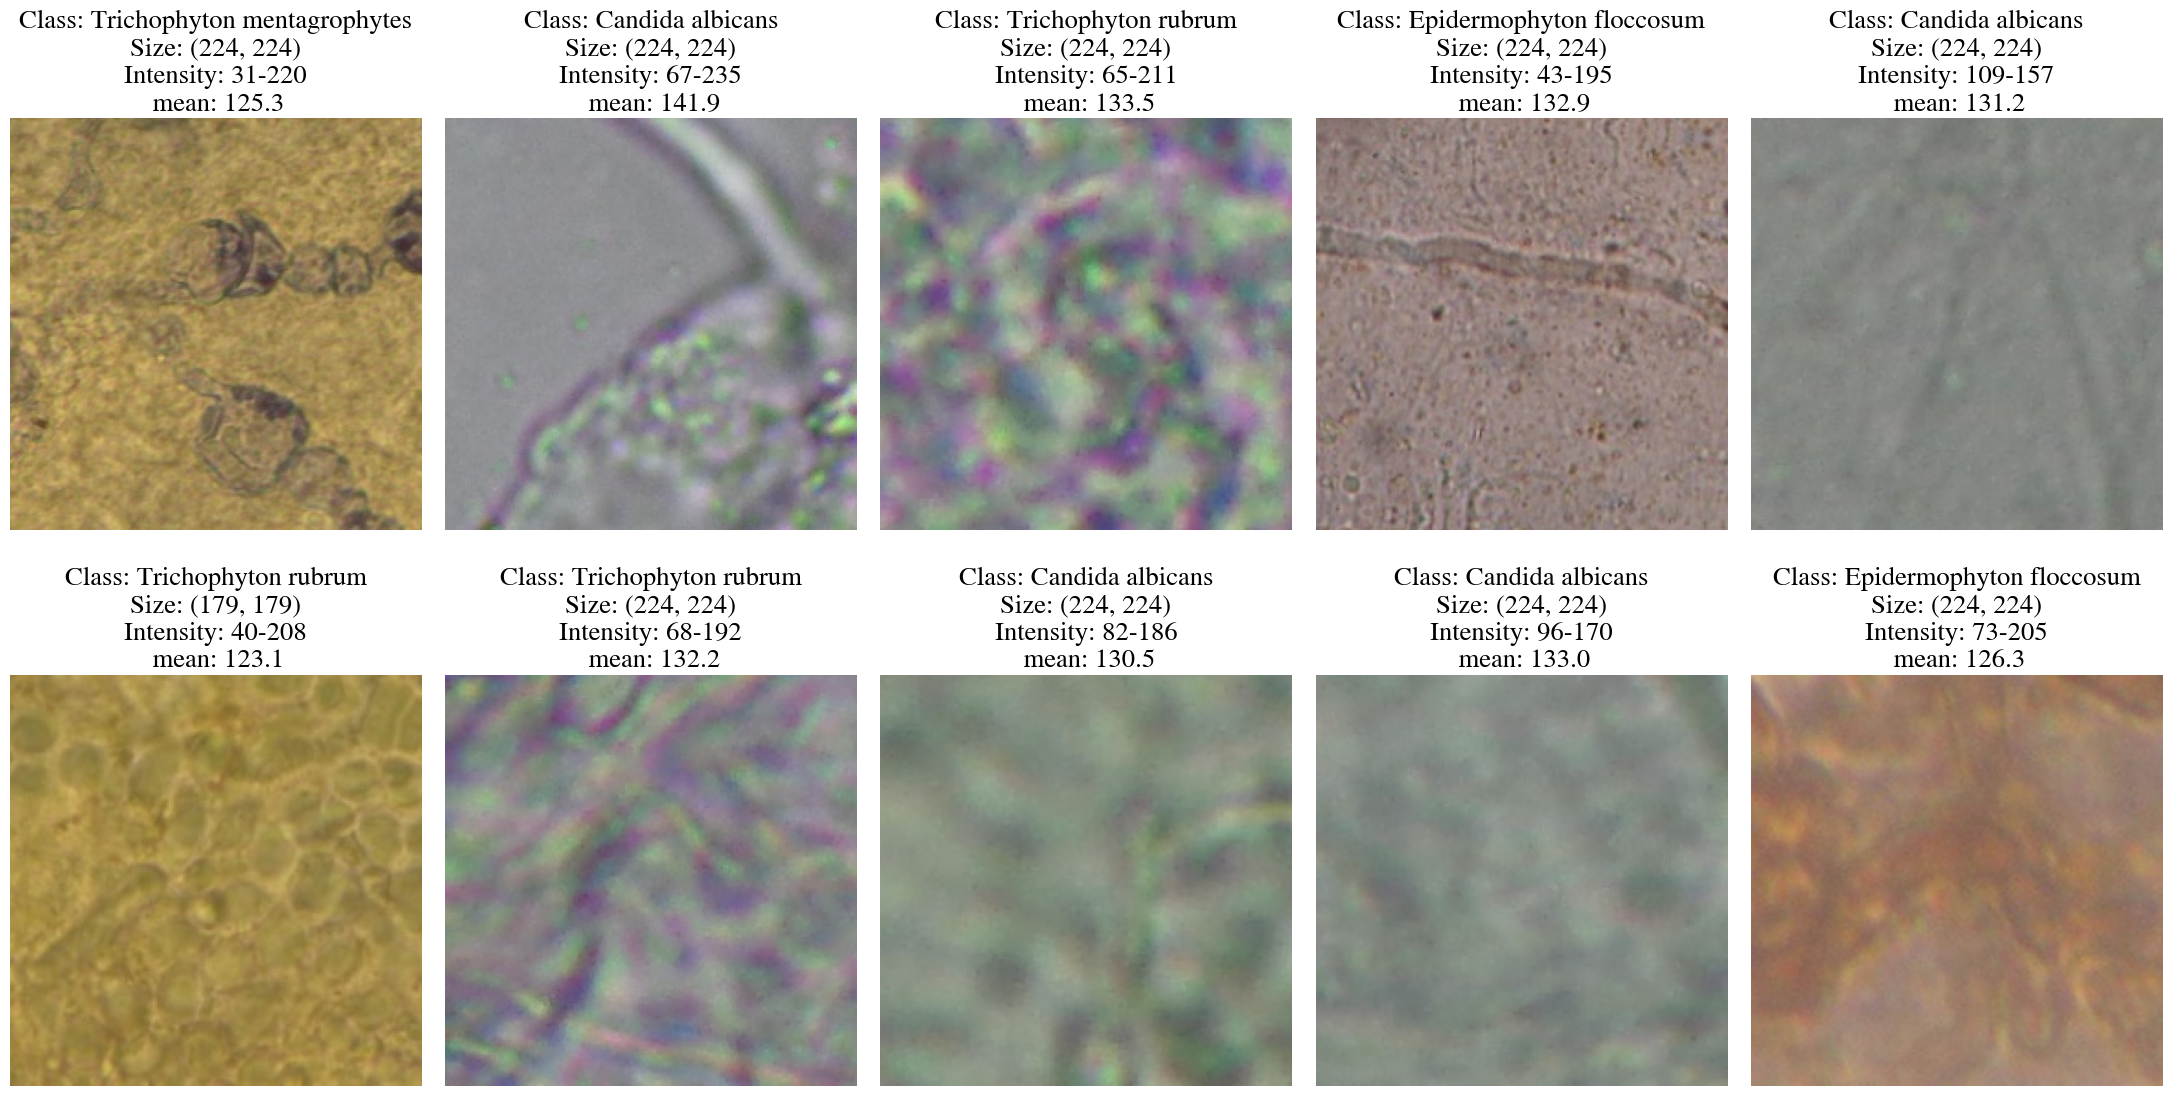

In [70]:
def supPlotimage(images, labels, row_num, col_num,verbose = 2):
    fig, axes = plt.subplots(row_num, col_num, figsize=(22, 12))
    for i, image in enumerate(images):
        row = i // col_num
        col = i % col_num
        
        axes[row, col].imshow(image)
        axes[row, col].axis('off')
        if verbose ==0:
            continue
        elif verbose ==1:
            axes[row, col].set_title(f"Class: {class_labels[labels[i]]}")
        elif verbose ==2:
            axes[row, col].set_title(f"Class: {class_labels[labels[i]]}\nSize: {image.size}\nIntensity: {round(np.min(image),1)}-{round(np.max(image),1)}\n mean: {round(np.mean(image),1)}")
        else:
            raise ValueError("Value for verbose should be an int, either 0, 1 or 2")
    
    plt.tight_layout()
    plt.savefig('./figures/example_images.png', dpi=300) 
    plt.show()

# Call the function for the 20 images and labels
supPlotimage(images,labels,row_num=2,col_num=5)

We also modify the above function to plot the intensity histograms of each of the images.

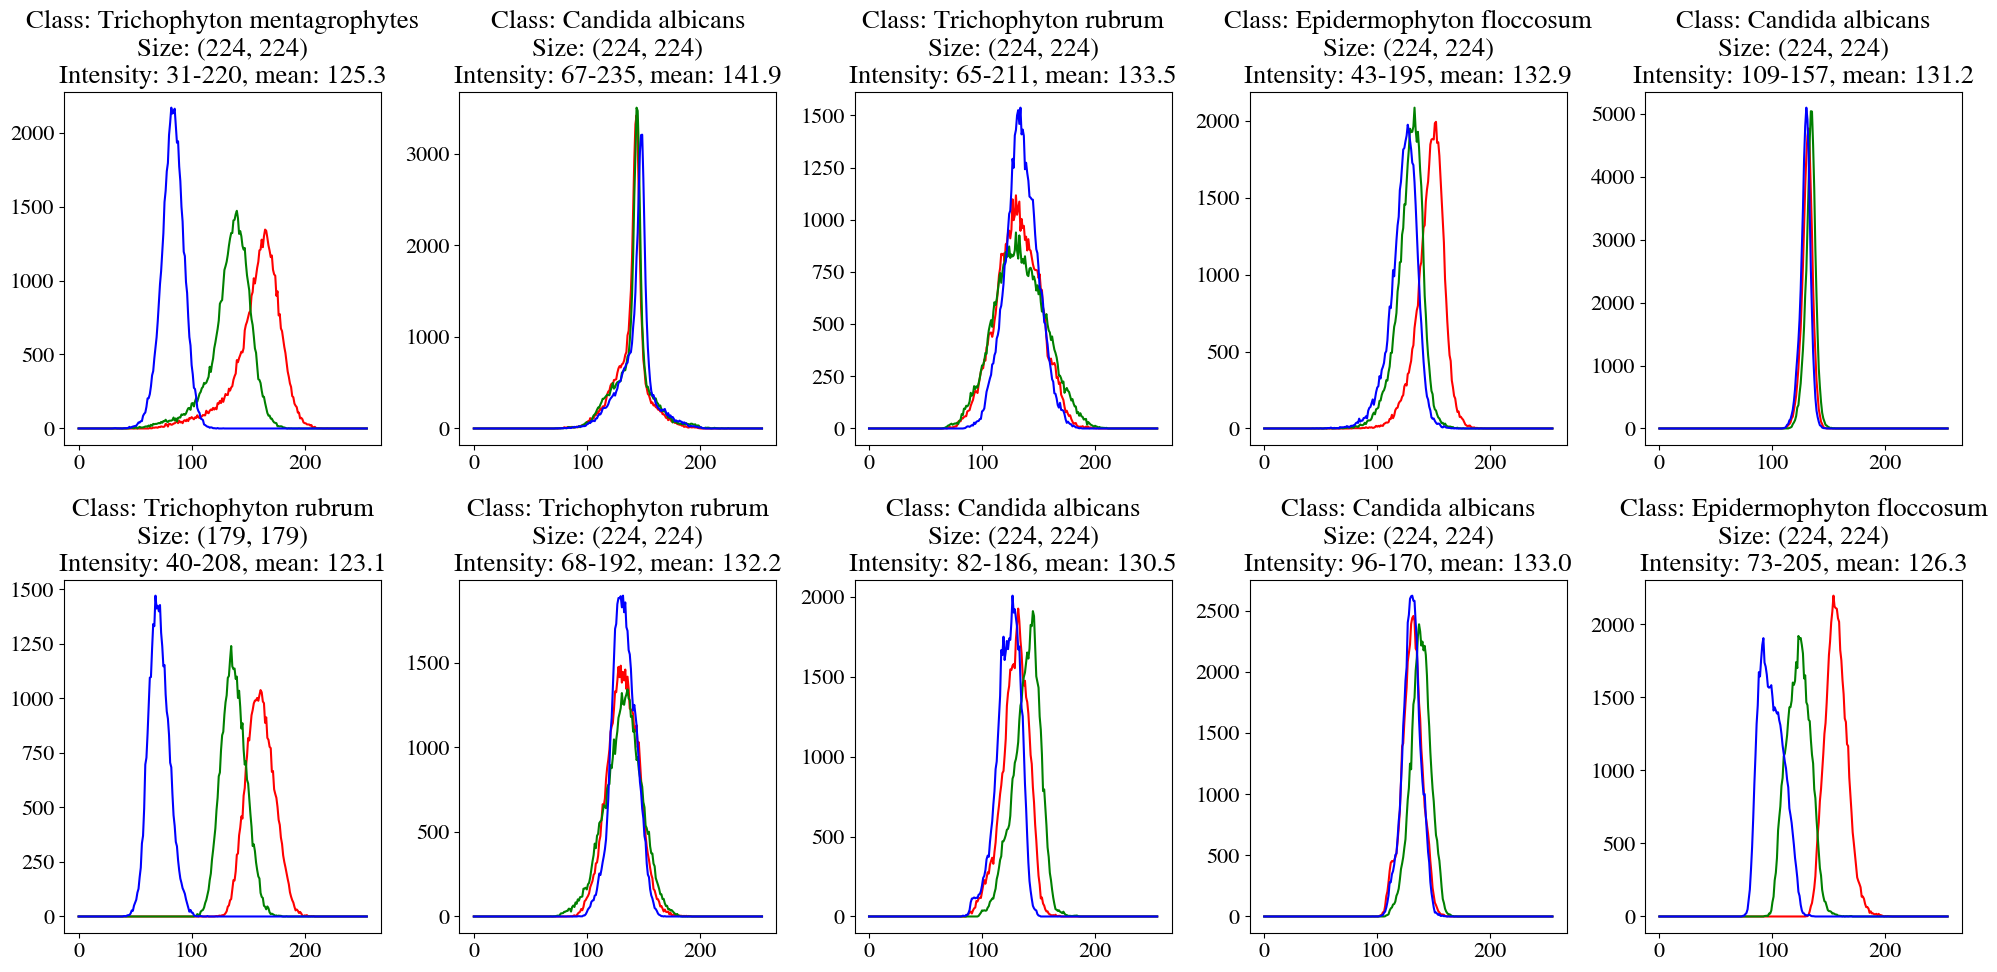

In [71]:
def supPlotimagehist(images, labels, row_num, col_num, verbose = 2,single = True, normalized = False):
    colors = ["red","green","blue"]
    fig, axes = plt.subplots(row_num, col_num, figsize=(20, 10))
    for i, image in enumerate(images):
        row = i // col_num
        col = i % col_num
        
        # Convert PIL image to numpy array
        image_array = np.array(image)
        if single and not normalized: 
            hist = np.histogram(image_array, bins=256, range=(0, 256))[0]
            axes[row, col].plot(hist)
        elif single and normalized:
            hist = np.histogram(image_array, bins=256, range=(0, 1))[0]
            axes[row, col].plot(hist)
        elif not single and normalized:
             for channel in range(3):
                hist = np.histogram(image_array[:, :, channel], bins=256, range=(0, 1))[0]
                axes[row, col].plot(hist, label=f"Channel {channel}")
        else:
            for channel in range(3):
                hist = np.histogram(image_array[:, :, channel], bins=256, range=(0, 256))[0]
                axes[row, col].plot(hist, label=f"Channel {channel}", color = colors[channel])
         
        if verbose == 0:
            continue
        elif verbose ==1:
            axes[row, col].set_title(f"Class: {class_labels[labels[i]]}")
        elif verbose ==2:
            axes[row, col].set_title(f"Class: {class_labels[labels[i]]}\nSize: {image.size}\nIntensity: {round(np.min(image),1)}-{round(np.max(image),1)}, mean: {round(np.mean(image),1)}")
        else:
            raise ValueError("Value for verbose should be an int, either 0, 1 or 2")
    
    plt.tight_layout()
    plt.savefig('./figures/example_images_histograms.png', dpi=300) 
    plt.show()

# Call the function for the 20 images and labels
supPlotimagehist(images, labels, row_num=2, col_num=5,single=False)

As we can see some images have a size of (179,179). Lets investigate if other sizes exist and their distribution in the dataset

In [18]:
size_counts = {}
for observation in df['images']:
    image = Image.open(observation)
    size = image.size[0]
    if size in size_counts.keys():
        size_counts[size] += 1
    else:
        size_counts[size] = 0
        
size_counts

{224: 6248, 179: 551}

As we can also observe the 179 b 179 pixel size images are the minority, making up only $8\%$ of the dataset

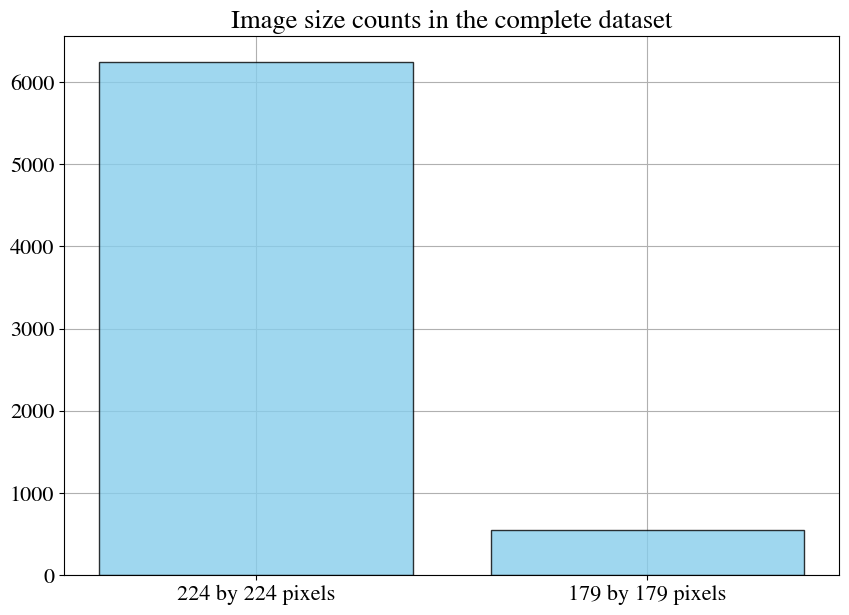

In [72]:
plt.figure(figsize = (10,7))
plt.bar(x = [f"{size} by {size} pixels" for size in size_counts.keys()],height = size_counts.values(), color = "skyblue", edgecolor = "k", alpha = 0.8)
plt.title("Image size counts in the complete dataset")
plt.savefig('./figures/image_size_distribution.png', dpi=300) 
plt.grid()

We can handle the resizing of the $179$ by $179$ images by utilizing BILINEAR interpolation of the PIL library. Additionally we convert to PIL object the rest of the images.

In [73]:
count = 0
for i,observation in enumerate(df['images']):
    image = Image.open(observation)
    size = image.size[0]
    if size == 179:
        count += 1
        resized_image = image.resize((224, 224), Image.BILINEAR)
        df['images'][i] = resized_image
        if count%100 == 0:
            plt.subplot(1, 2, 1)  # First subplot
            plt.imshow(image)
            plt.axis("off")
            plt.title(f"Original Image: {image.size}")

            plt.subplot(1, 2, 2)  # Second subplot
            plt.imshow(resized_image)
            plt.axis("off")
            plt.title(f"Resized Image: {resized_image.size}")
            plt.tight_layout()  # To ensure proper spacing
            plt.savefig('./figures/resizing_examples.png', dpi=300) 
            plt.show()  # Display the subplot
    else:
        df['images'][i] = image

NameError: name 'df' is not defined

In [21]:
df.head()

,images,labels
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0


# **Dataset Creation**
Its intresting to see how much more information we can achieve with the colored RGB images vs grayscale images, so we also create a grayscale dataset

In [22]:
df_gray = pd.DataFrame()
df_gray['images'] = df['images'].apply(lambda x: x.convert("L"))
df_gray['labels'] = df['labels']

lets now observe an example of the gray dataset compared to the RGB one

NameError: name 'df' is not defined

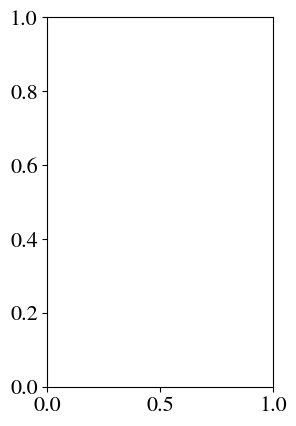

In [74]:
plt.subplot(1, 2, 1)  
plt.imshow(df['images'][233])
plt.axis("off")
plt.title(f"Original Image: {image.size}")

plt.subplot(1, 2, 2)  
plt.imshow(df_gray['images'][233], cmap = "gray" )
plt.axis("off")
plt.title(f"Gray Image: {resized_image.size}")
plt.tight_layout() 
plt.savefig('./figures/gray_scale_conversion.png', dpi=300) 
plt.show() 

We go ahead and convert the PIL objects to numpy pixel value arrays to save these two datasets

In [24]:
df['images'] = df['images'].apply(lambda x :  np.array(x))
df_gray['images'] = df_gray['images'].apply(lambda x :  np.array(x))

In [25]:
df_gray.to_csv('gray_fungi.csv', index=False)
df.to_csv('rgb_fungi.csv', index=False)

Additionally we create flattened datasets for visualization and classical ML approaches

In [26]:
df_flattened = pd.DataFrame()
df_flattened['images'] = df['images'].apply(lambda x :  x.flatten())
df_flattened['labels'] = df['labels']

df_gray_flattened = pd.DataFrame()
df_gray_flattened['images'] = df_gray['images'].apply(lambda x :  x.flatten())
df_gray_flattened['labels'] = df_gray['labels']

In [27]:
df_flattened.to_csv('flattened_gray_fungi.csv', index=False)
df_gray_flattened.to_csv('flattened_rgb_fungi.csv', index=False)

We wont use these dataframes further is this notebook and we need to free up RAM

In [30]:
del df, df_gray

# **Data visualization**

Before any visualization we need to standardize our flattened data

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

First we standardize the X_gray dataset

In [34]:
X_gray = np.vstack(df_gray_flattened['images'])
X_gray = scaler.fit_transform(X_gray)

Then the colored dataset

In [36]:
X_rgb = np.vstack(df_flattened['images'])
X_rgb = scaler.fit_transform(X_rgb)

In [47]:
pca_gray = PCA(n_components = 2)
X_pca_gray = pca_gray.fit_transform(X_gray)

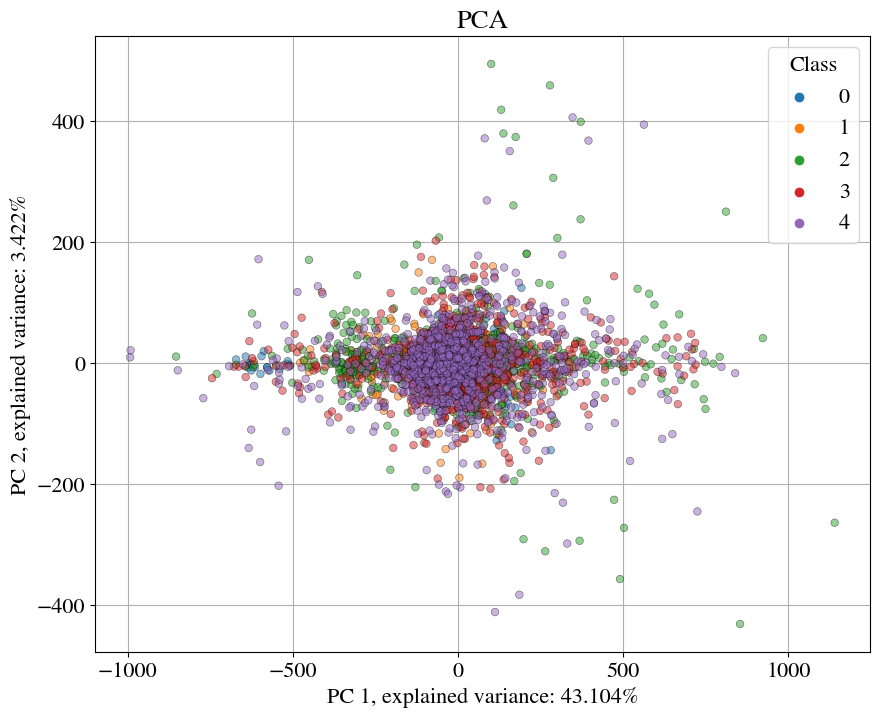

In [75]:

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca_gray[:,0], y=X_pca_gray[:,1], hue=df_gray_flattened['labels'].values, palette='tab10', s=30, alpha = 0.5,edgecolor='black')
plt.title('PCA')
plt.grid()
plt.xlabel(f'PC 1, explained variance: {round(pca_gray.explained_variance_ratio_[0]*100,3)}%')
plt.ylabel(f'PC 2, explained variance: {round(pca_gray.explained_variance_ratio_[1]*100,3)}%')
plt.legend(title='Class')
plt.savefig('./figures/pca.png', dpi=300) 
plt.show()